In [27]:
import gpxpy
import pandas as pd
import folium
from folium.plugins import MeasureControl
from haversine import haversine
import json
import os
import colorsys
import random
import math

def load_gpx_to_dataframe(gpx_file):
    """
    Load a GPX file into a pandas DataFrame with distance calculations
    """
    with open(gpx_file, 'r') as f:
        gpx = gpxpy.parse(f)
    
    # Extract points
    points = []
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                points.append({
                    'latitude': point.latitude,
                    'longitude': point.longitude,
                    'elevation': point.elevation if point.elevation else 0,
                    'time': point.time
                })
    
    # Convert to DataFrame
    df = pd.DataFrame(points)
    
    # Calculate cumulative distance
    df['segment_distance'] = 0.0
    for i in range(1, len(df)):
        point1 = (df.iloc[i-1]['latitude'], df.iloc[i-1]['longitude'])
        point2 = (df.iloc[i]['latitude'], df.iloc[i]['longitude'])
        df.loc[i, 'segment_distance'] = haversine(point1, point2, unit='km')
    
    df['cumulative_distance'] = df['segment_distance'].cumsum()
    
    # Calculate elevation gain/loss
    df['elevation_change'] = 0.0
    for i in range(1, len(df)):
        df.loc[i, 'elevation_change'] = df.iloc[i]['elevation'] - df.iloc[i-1]['elevation']
    
    df['elevation_gain'] = df['elevation_change'].apply(lambda x: max(0, x))
    df['elevation_loss'] = df['elevation_change'].apply(lambda x: abs(min(0, x)))
    df['cumulative_elevation_gain'] = df['elevation_gain'].cumsum()
    
    return df

def get_distinct_colors(n):
    """
    Generate n visually distinct colors for routes
    """
    colors = []
    for i in range(n):
        # Use HSV color space to generate evenly distributed colors
        h = i / n
        s = 0.8 + random.uniform(-0.1, 0.1)  # Add slight randomness to saturation
        v = 0.9 + random.uniform(-0.1, 0.1)  # Add slight randomness to value
        r, g, b = colorsys.hsv_to_rgb(h, s, v)
        # Convert to hex
        color = "#{:02x}{:02x}{:02x}".format(int(r*255), int(g*255), int(b*255))
        colors.append(color)
    return colors

def generate_rv_stops(route_df, target_distance=125):
    """
    Generate RV stop points at approximately target_distance intervals
    """
    total_distance = route_df['cumulative_distance'].iloc[-1]
    num_days = math.ceil(total_distance / target_distance)
    
    stops = []
    for day in range(1, num_days):
        target_distance_km = day * target_distance
        # Find the closest point to the target distance
        closest_idx = (route_df['cumulative_distance'] - target_distance_km).abs().idxmin()
        stops.append({
            'day': day,
            'distance_km': route_df.loc[closest_idx, 'cumulative_distance'],
            'latitude': route_df.loc[closest_idx, 'latitude'],
            'longitude': route_df.loc[closest_idx, 'longitude'],
            'elevation': route_df.loc[closest_idx, 'elevation'],
            'elevation_gain_so_far': route_df.loc[closest_idx, 'cumulative_elevation_gain'],
            'index': closest_idx
        })
    
    return stops

def create_interactive_multi_route_map(gpx_files, target_daily_distance=125):
    """
    Create an interactive map showing multiple routes with hover information
    
    Parameters:
    - gpx_files: List of GPX file paths
    - target_daily_distance: Target distance per day in km (default: 125)
    
    Returns:
    - Folium map object
    - HTML filename
    """
    route_data = {}
    all_lats = []
    all_lons = []
    
    # Process all GPX files
    for gpx_file in gpx_files:
        route_name = os.path.basename(gpx_file).replace('.gpx', '')
        print(f"Processing route: {route_name}")
        
        # Load and process route
        route_df = load_gpx_to_dataframe(gpx_file)
        
        # Calculate RV stops
        rv_stops = generate_rv_stops(route_df, target_daily_distance)
        
        # Store route data
        route_data[route_name] = {
            'df': route_df,
            'rv_stops': rv_stops,
            'total_distance': route_df['cumulative_distance'].iloc[-1],
            'total_elevation_gain': route_df['cumulative_elevation_gain'].iloc[-1]
        }
        
        # Collect coordinates for centering the map
        all_lats.extend(route_df['latitude'].tolist())
        all_lons.extend(route_df['longitude'].tolist())
    
    # Create a map centered on all routes
    center_lat = sum(all_lats) / len(all_lats)
    center_lon = sum(all_lons) / len(all_lons)
    multi_route_map = folium.Map(location=[center_lat, center_lon], zoom_start=8)
    
    # Add measurement tools
    multi_route_map.add_child(MeasureControl())
    
    # Generate distinct colors for each route
    colors = get_distinct_colors(len(route_data))
    
    custom_js = """
    <script>
    // Store all route data for quick lookup
    var routeDataPoints = {};
    
    // Create hover info box
    var infoDiv = document.createElement('div');
    infoDiv.style.cssText = 'position: fixed; bottom: 10px; left: 10px; background: white; padding: 10px; border-radius: 5px; border: 1px solid #ccc; z-index: 1000; display: none; min-width: 200px; box-shadow: 0 1px 5px rgba(0,0,0,0.4);';
    infoDiv.innerHTML = '<h4 id="route-name" style="margin: 0 0 5px 0;"></h4><div id="distance-info"></div><div id="elevation-info"></div><div id="elev-gain-info"></div>';
    document.body.appendChild(infoDiv);
    
    function showRouteInfo(routeName, point) {
        // Find the info elements
        var routeNameEl = document.getElementById('route-name');
        var distanceEl = document.getElementById('distance-info');
        var elevationEl = document.getElementById('elevation-info');
        var elevGainEl = document.getElementById('elev-gain-info');
        
        // Update info
        if (routeNameEl) routeNameEl.textContent = routeName;
        if (distanceEl) distanceEl.textContent = 'Distance from start: ' + point.distance.toFixed(2) + ' km';
        if (elevationEl) elevationEl.textContent = 'Current elevation: ' + point.elevation.toFixed(0) + ' m';
        if (elevGainEl) elevGainEl.textContent = 'Cumulative gain: ' + point.elevGain.toFixed(0) + ' m';
        
        // Show the div
        infoDiv.style.display = 'block';
    }
    
    function hideRouteInfo() {
        infoDiv.style.display = 'none';
    }
    
    // Wait for the map to be fully loaded
    document.addEventListener('DOMContentLoaded', function() {
        // Give the map time to initialize
        setTimeout(function() {
            console.log("Map initialization complete, setting up hover events");
            
            // Get all polylines (routes)
            var polylines = document.querySelectorAll('path.leaflet-interactive');
            console.log("Found " + polylines.length + " route lines");
            
            polylines.forEach(function(path) {
                // Set mouseover and mouseout events
                path.addEventListener('mouseover', function(e) {
                    // Get route name from the path's tooltip if available
                    var tooltip = path.getAttribute('data-route');
                    if (tooltip && routeDataPoints[tooltip]) {
                        console.log("Mouseover activated for route: " + tooltip);
                        // Enable hover tracking
                        path.setAttribute('data-hover-active', 'true');
                    }
                });
                
                path.addEventListener('mouseout', function() {
                    path.removeAttribute('data-hover-active');
                    hideRouteInfo();
                });
            });
            
            // Add mousemove listener to the map container
            var mapContainer = document.querySelector('.leaflet-container');
            if (mapContainer) {
                mapContainer.addEventListener('mousemove', function(e) {
                    // Find the active route
                    var activeRoute = document.querySelector('[data-hover-active="true"]');
                    if (!activeRoute) return;
                    
                    var routeName = activeRoute.getAttribute('data-route');
                    if (!routeName || !routeDataPoints[routeName]) return;
                    
                    // Get the map instance and convert pixel to latlng
                    var map = null;
                    for (var key in window) {
                        if (window[key] && window[key]._container && 
                            window[key]._container.className.indexOf('leaflet-container') !== -1) {
                            map = window[key];
                            break;
                        }
                    }
                    
                    if (!map) return;
                    
                    // Get the mouse position relative to the map container
                    var rect = mapContainer.getBoundingClientRect();
                    var x = e.clientX - rect.left;
                    var y = e.clientY - rect.top;
                    var containerPoint = L.point(x, y);
                    var latlng = map.containerPointToLatLng(containerPoint);
                    
                    // Find closest point
                    var routePoints = routeDataPoints[routeName];
                    var minDist = Infinity;
                    var closestPoint = null;
                    
                    for (var i = 0; i < routePoints.length; i++) {
                        var point = routePoints[i];
                        var dist = map.distance(latlng, L.latLng(point.lat, point.lng));
                        if (dist < minDist) {
                            minDist = dist;
                            closestPoint = point;
                        }
                    }
                    
                    // Show info if point is close enough (within 100 meters)
                    if (closestPoint && minDist < 100) {
                        showRouteInfo(routeName, closestPoint);
                    } else {
                        hideRouteInfo();
                    }
                });
            }
        }, 1000); // Wait 1 second for map to initialize completely
    });
    </script>
    """
    
    # Add the custom JavaScript to the map
    multi_route_map.get_root().html.add_child(folium.Element(custom_js))
    
    # Process each route
    for i, (route_name, data) in enumerate(route_data.items()):
        route_df = data['df']
        color = colors[i]
        
        # Prepare route data for JavaScript
        js_points = []
        for _, row in route_df.iterrows():
            js_points.append({
                'lat': row['latitude'],
                'lng': row['longitude'],
                'elevation': row['elevation'],
                'distance': row['cumulative_distance'],
                'elevGain': row['cumulative_elevation_gain']
            })
        
        # Add the route points data to JavaScript
        js_points_str = json.dumps(js_points)
        multi_route_map.get_root().script.add_child(folium.Element(
            f'routeDataPoints["{route_name}"] = {js_points_str};\n' +
            f'console.log("Added {len(js_points)} points for route {route_name}");'
        ))
        
        # Create the route line with a clean ID for better JavaScript handling
        route_id = f"route_{route_name.replace(' ', '_').replace('.', '_')}"
        points = [(row['latitude'], row['longitude']) for _, row in route_df.iterrows()]
        
        # Create the route line with proper event handling
        route_line = folium.PolyLine(
            points,
            color=color,
            weight=4,
            opacity=0.8,
            tooltip=f"{route_name} - {data['total_distance']:.1f} km"
        )
        
        # Store index in options for reference in JavaScript
        route_line.add_to(multi_route_map)
        
        # Add a custom JavaScript snippet to help identify this route
        multi_route_map.get_root().script.add_child(folium.Element(
            f"// Route index mapping: {i} = {route_name}"
        ))
        
        # Add start marker
        folium.Marker(
            [route_df.iloc[0]['latitude'], route_df.iloc[0]['longitude']],
            popup=f"Start: {route_name}",
            icon=folium.Icon(color='green', icon='play', prefix='fa')
        ).add_to(multi_route_map)
        
        # Add end marker
        folium.Marker(
            [route_df.iloc[-1]['latitude'], route_df.iloc[-1]['longitude']],
            popup=f"End: {route_name}",
            icon=folium.Icon(color='red', icon='stop', prefix='fa')
        ).add_to(multi_route_map)
        
        # Add RV stop markers
        for stop in data['rv_stops']:
            folium.Marker(
                [stop['latitude'], stop['longitude']],
                popup=f"{route_name} - Day {stop['day']} Stop<br>Distance: {stop['distance_km']:.1f} km",
                icon=folium.Icon(color=color, icon='flag', prefix='fa')
            ).add_to(multi_route_map)
    
    # Add a legend
    legend_html = """
    <div style="position: fixed; bottom: 50px; right: 10px; background: white; padding: 10px; border: 1px solid grey; z-index:1000; border-radius: 5px;">
    <h4>Routes</h4>
    """
    
    for i, route_name in enumerate(route_data.keys()):
        color = colors[i]
        legend_html += f'<div><span style="background-color:{color}; width:15px; height:15px; display:inline-block;"></span> {route_name}</div>'
    
    legend_html += "</div>"
    multi_route_map.get_root().html.add_child(folium.Element(legend_html))
    
    # Add a summary table at the top
    summary_html = """
    <div style="position: fixed; top: 10px; right: 10px; background: white; padding: 10px; border: 1px solid grey; z-index:1000; border-radius: 5px;">
    <h4>Route Summary</h4>
    <table style="width:100%">
      <tr>
        <th>Route</th>
        <th>Distance (km)</th>
        <th>Elevation Gain (m)</th>
        <th>Est. Days</th>
      </tr>
    """
    
    for i, (route_name, data) in enumerate(route_data.items()):
        color = colors[i]
        days = len(data['rv_stops']) + 1
        summary_html += f"""
        <tr>
          <td><span style="background-color:{color}; width:12px; height:12px; display:inline-block;"></span> {route_name}</td>
          <td>{data['total_distance']:.1f}</td>
          <td>{data['total_elevation_gain']:.0f}</td>
          <td>{days}</td>
        </tr>
        """
    
    summary_html += """
    </table>
    </div>
    """
    multi_route_map.get_root().html.add_child(folium.Element(summary_html))
    
    # Save and return the map
    html_filename = "all_routes_interactive_map.html"
    multi_route_map.save(html_filename)
    print(f"Interactive map saved to {html_filename}")
    
    return multi_route_map, html_filename

def main(gpx_files, target_daily_distance=125):
    """
    Main function to create an interactive multi-route map
    
    Parameters:
    - gpx_files: List of GPX file paths
    - target_daily_distance: Target distance per day in km (default: 125)
    
    Returns:
    - Path to the generated HTML file
    """
    _, html_file = create_interactive_multi_route_map(gpx_files, target_daily_distance)
    print(f"Interactive map with hover functionality created: {html_file}")
    return html_file

# Example usage:
"""
gpx_files = ['santa_monica_to_vegas_route1.gpx', 'santa_monica_to_vegas_route2.gpx']
main(gpx_files, target_daily_distance=125)
"""

"\ngpx_files = ['santa_monica_to_vegas_route1.gpx', 'santa_monica_to_vegas_route2.gpx']\nmain(gpx_files, target_daily_distance=125)\n"

In [28]:
gpx_files = ['gpx/HS TSP Solo.gpx', 'gpx/TSP_solo.gpx', 'gpx/JP TSP Solo.gpx']

In [29]:
main(gpx_files, target_daily_distance=125)

Processing route: HS TSP Solo
Processing route: TSP_solo
Processing route: JP TSP Solo


/var/folders/ss/kjxldrfs36qgygzmg25sqy100000gn/T/ipykernel_79303/1450829588.py:291: UserWarning: color argument of Icon should be one of: {'gray', 'beige', 'blue', 'cadetblue', 'lightblue', 'pink', 'black', 'darkgreen', 'orange', 'lightred', 'lightgray', 'lightgreen', 'darkred', 'darkblue', 'green', 'purple', 'darkpurple', 'white', 'red'}.
  icon=folium.Icon(color=color, icon='flag', prefix='fa')


Interactive map saved to all_routes_interactive_map.html
Interactive map with hover functionality created: all_routes_interactive_map.html


'all_routes_interactive_map.html'

#### Check for errors in gpx file

In [11]:
from gpx_analyser import analyze_gpx_file

Analyzing GPX file: gpx/TSP_solo.gpx
Basic Information:
  - Tracks: 1
  - Segments: 1
  - Total points: 8913

Point Distribution Analysis:
  - Total distance: 466.44 km
  - Average distance between points: 52.34 m
  - Median distance between points: 34.97 m
  - Max distance between points: 945.49 m
  - Min distance between points: 0.01 m

Potential Issues - Large Jumps Detected:
  - Point 3825: 933.32 m jump from previous point
    Location: 34.7252385, -117.0616279
  - Point 3826: 945.49 m jump from previous point
    Location: 34.7278241, -117.0517721
  - Point 3887: 543.01 m jump from previous point
    Location: 34.7400799, -117.0289496
  - Point 6068: 689.27 m jump from previous point
    Location: 35.2830763, -116.0682274
  - Point 6700: 686.51 m jump from previous point
    Location: 35.3791828, -115.8945741
  - Point 8352: 773.01 m jump from previous point
    Location: 35.6744675, -115.3808103
  - Point 8353: 723.99 m jump from previous point
    Location: 35.6808389, -115.379

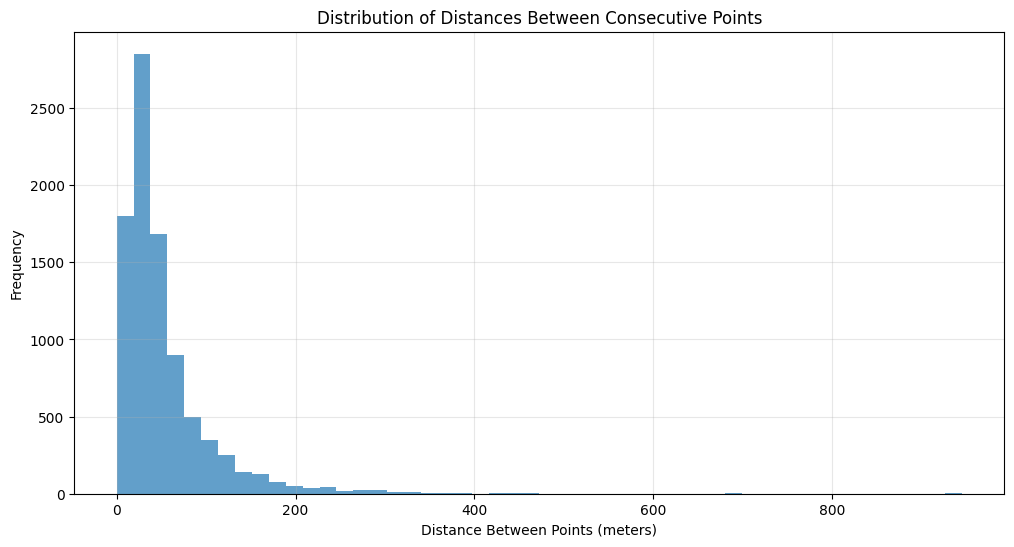

In [12]:
analysis = analyze_gpx_file('gpx/TSP_solo.gpx')